## Analysis of FFPE Prostate Dataset

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
#import scanorama
import csv
from sklearn.metrics.pairwise import cosine_distances

import SpatialDE

plt.rcParams['figure.figsize']=(8,8)


%load_ext autoreload
%autoreload 2

In [3]:
ffpe_human_prostate = sc.read_visium('FFPE_Visium_Human_Prostate',count_file='Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5')
ffpe_human_prostate.var_names_make_unique()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'FFPE_Visium_Human_Prostate/Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [19]:
#Calculate some QC metrics for the data
ffpe_human_prostate.var["mt"] = ffpe_human_prostate.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(ffpe_human_prostate, qc_vars=["mt"], inplace=True)

<IPython.core.display.Javascript object>


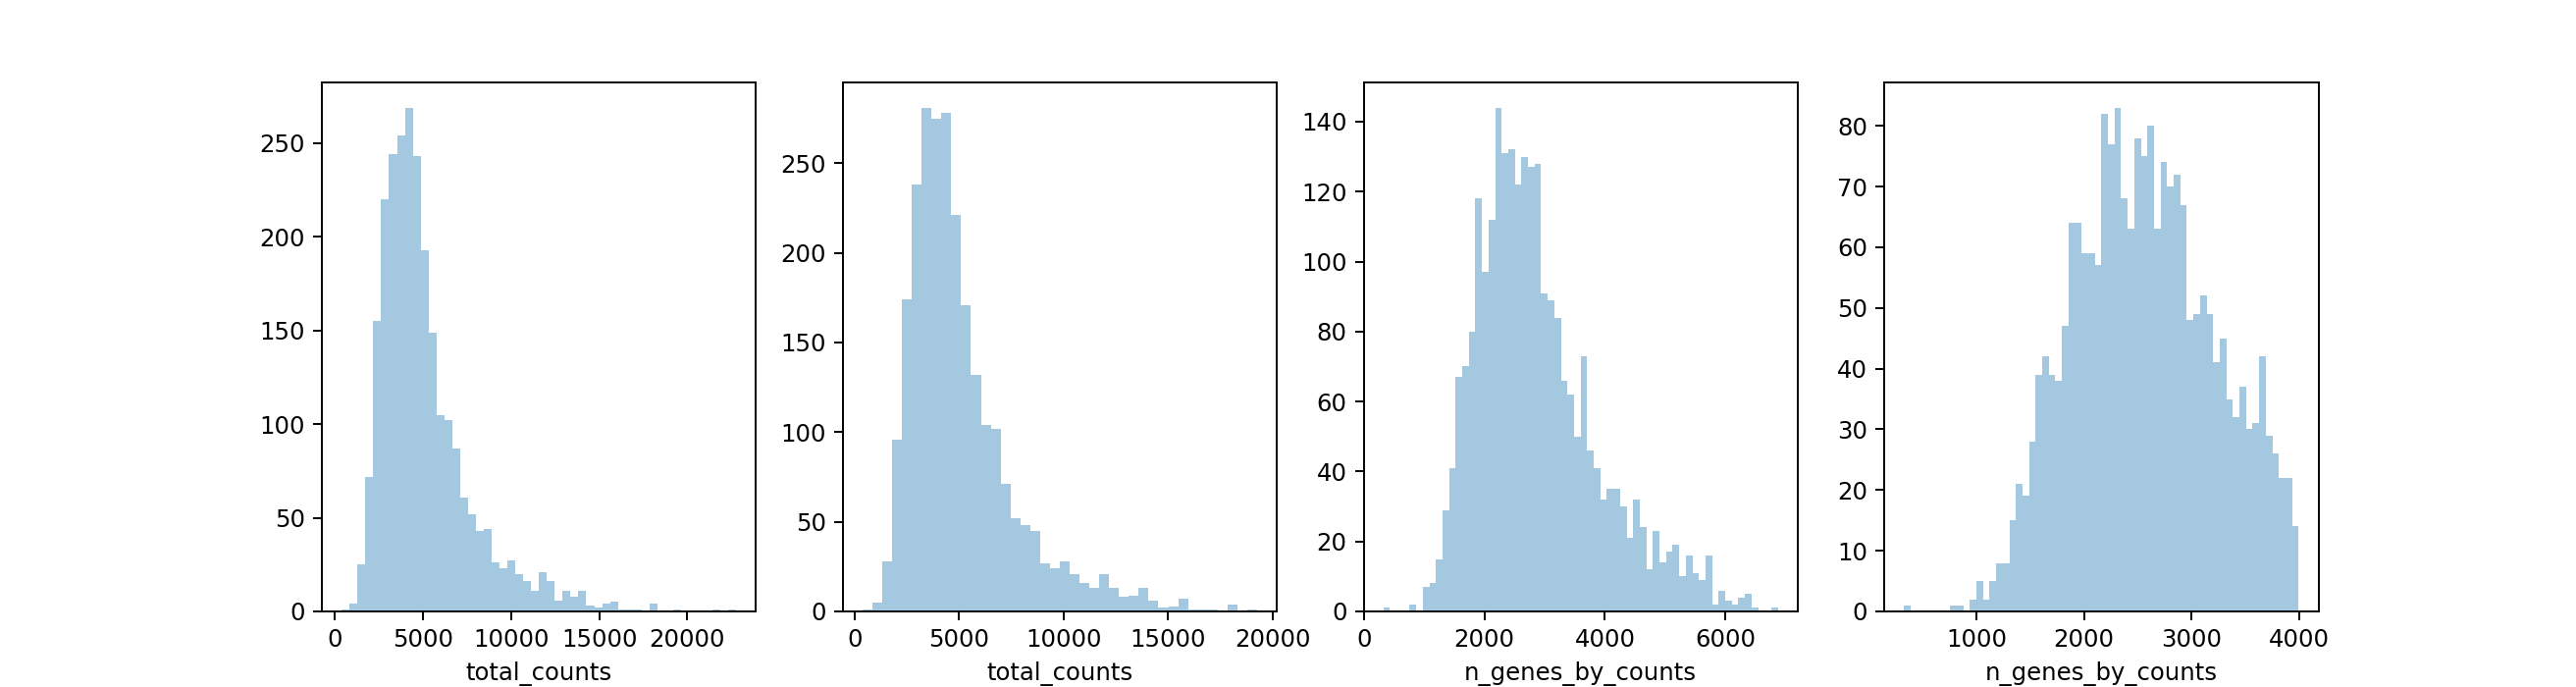

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


<IPython.core.display.Javascript object>


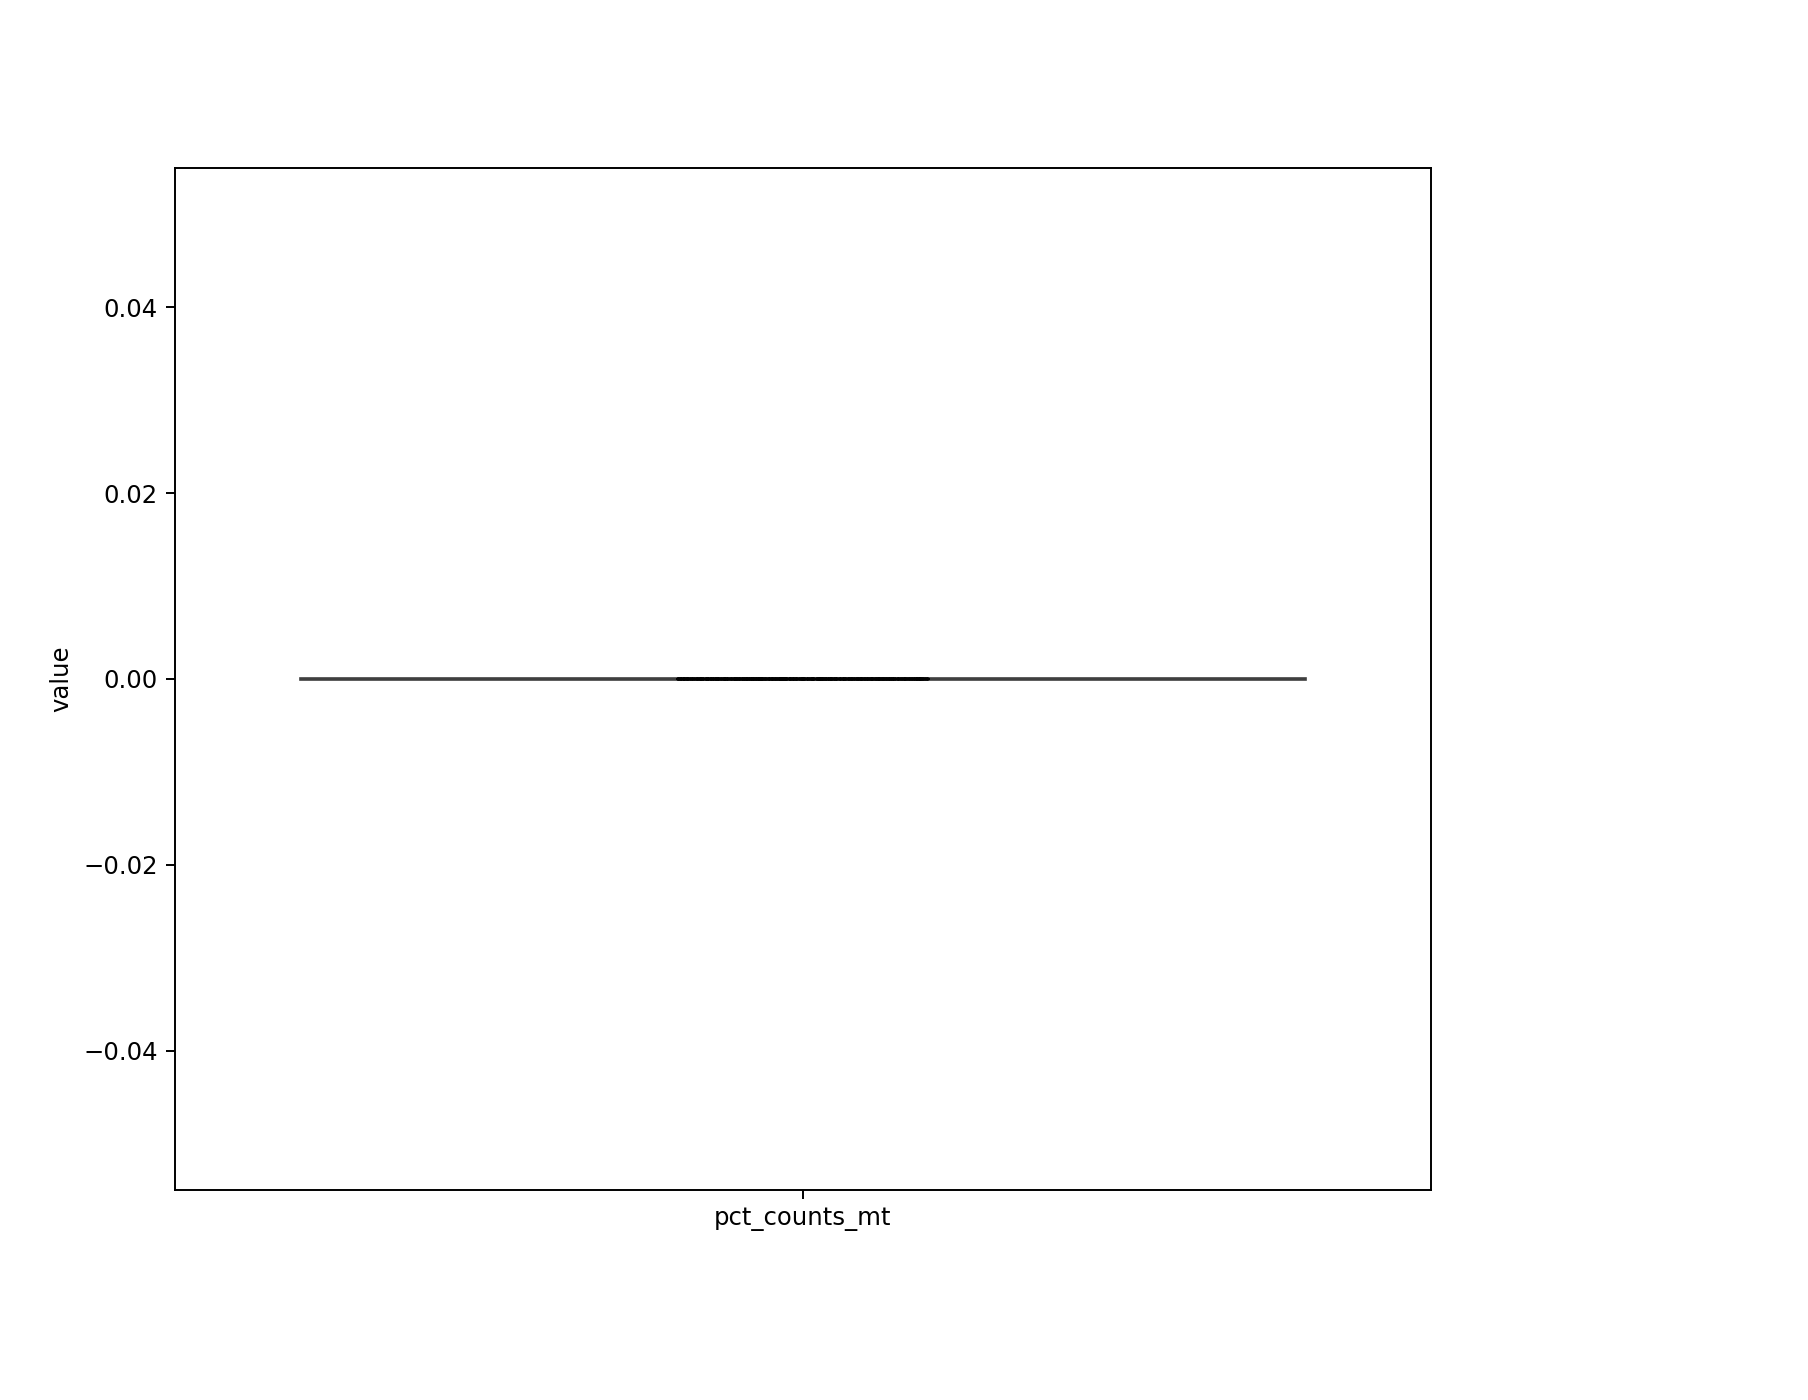

In [20]:
#Visualise some QC metrics for the data
%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(ffpe_human_prostate.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ffpe_human_prostate.obs["total_counts"][ffpe_human_prostate.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(ffpe_human_prostate.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(ffpe_human_prostate.obs["n_genes_by_counts"][ffpe_human_prostate.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(ffpe_human_prostate,['pct_counts_mt'])

In [21]:
ffpe_human_prostate

AnnData object with n_obs × n_vars = 2543 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [22]:
#Perform some filtering
sc.pp.filter_cells(ffpe_human_prostate, min_counts=2000)
print(f'Number of cells after min count filter: {ffpe_human_prostate.n_obs}')
sc.pp.filter_cells(ffpe_human_prostate, max_counts=15000)
print(f'Number of cells after max count filter: {ffpe_human_prostate.n_obs}')
ffpe_human_prostate = ffpe_human_prostate[ffpe_human_prostate.obs["pct_counts_mt"] < 10]
print(f"#cells after MT filter: {ffpe_human_prostate.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ffpe_human_prostate, min_cells=10)
print(f'Number of genes after cell filter: {ffpe_human_prostate.n_vars}')
sc.pp.filter_cells(ffpe_human_prostate, min_genes = 2000)
print(f'Number of cells after gene filter: {ffpe_human_prostate.n_obs}')

Trying to set attribute `.var` of view, copying.


Number of cells after min count filter: 2477
Number of cells after max count filter: 2457
#cells after MT filter: 2457
Number of genes after cell filter: 14181
Number of cells after gene filter: 2051


In [23]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(ffpe_human_prostate, inplace=True)
sc.pp.log1p(ffpe_human_prostate)
sc.pp.highly_variable_genes(ffpe_human_prostate, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


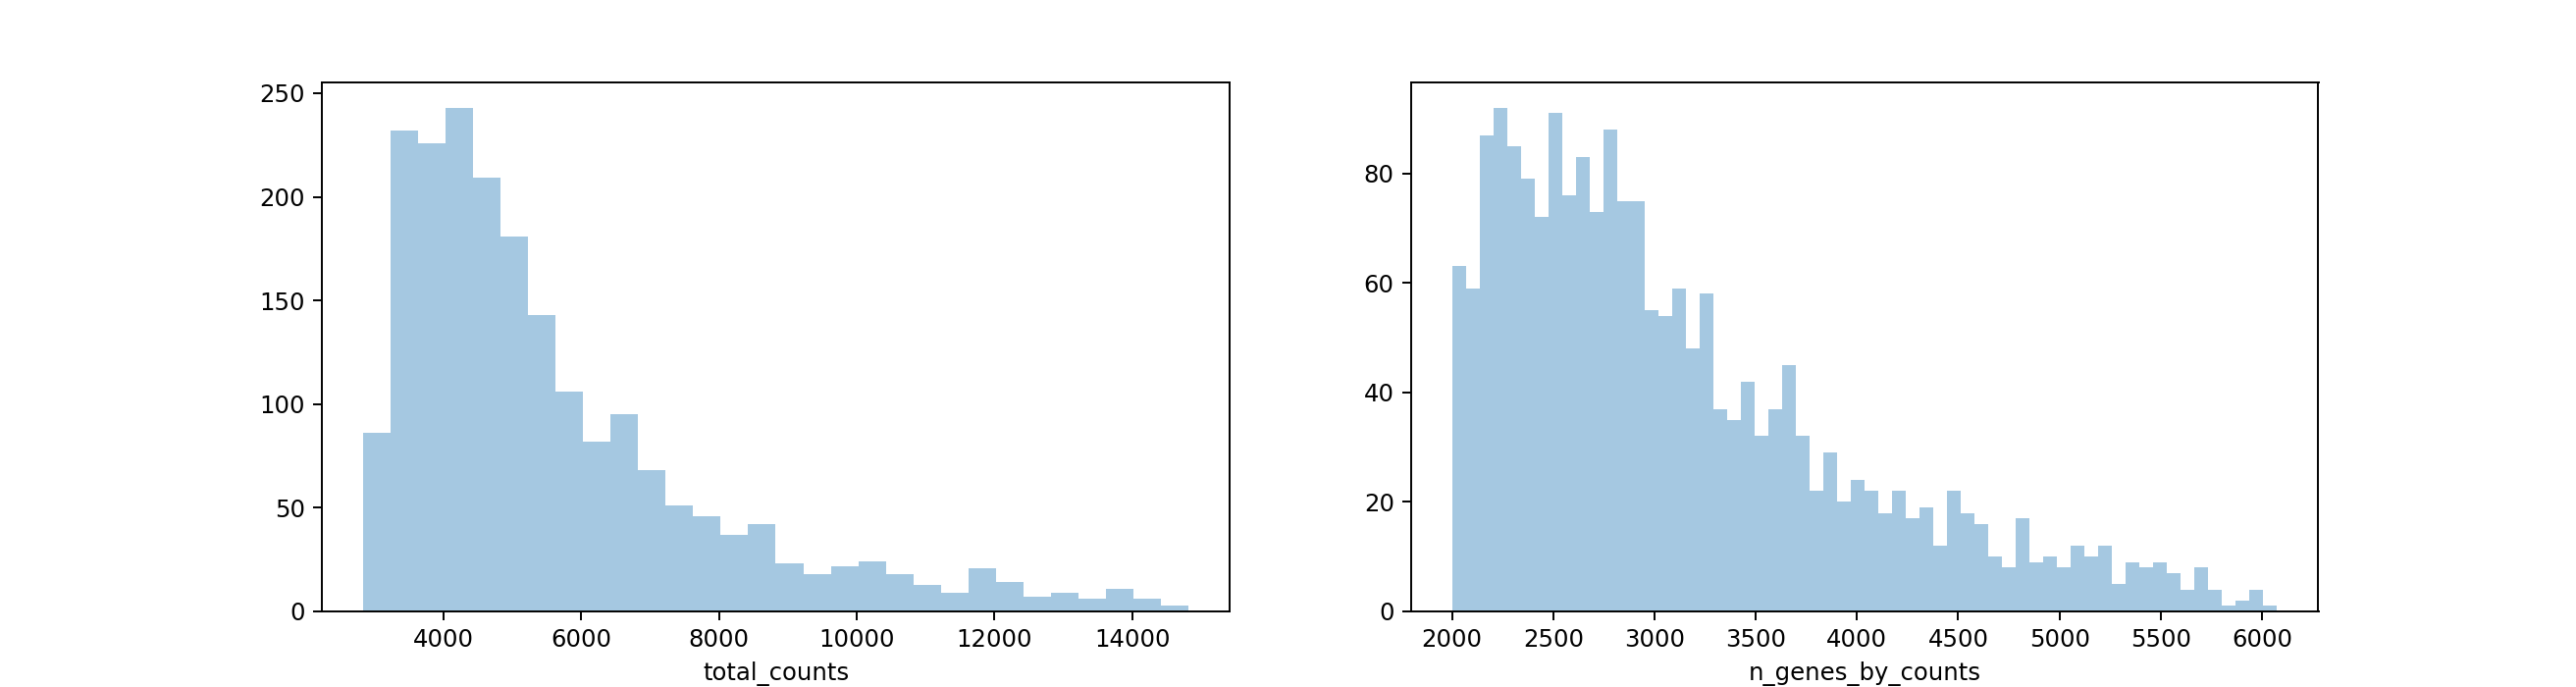

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

In [25]:
#Look at distribution after normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(ffpe_human_prostate.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ffpe_human_prostate.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [26]:
#Perform next steps in cluster identification
sc.pp.pca(ffpe_human_prostate,n_comps=20)
sc.pp.neighbors(ffpe_human_prostate)
sc.tl.umap(ffpe_human_prostate)
sc.tl.leiden(ffpe_human_prostate, key_added='clusters')

<IPython.core.display.Javascript object>


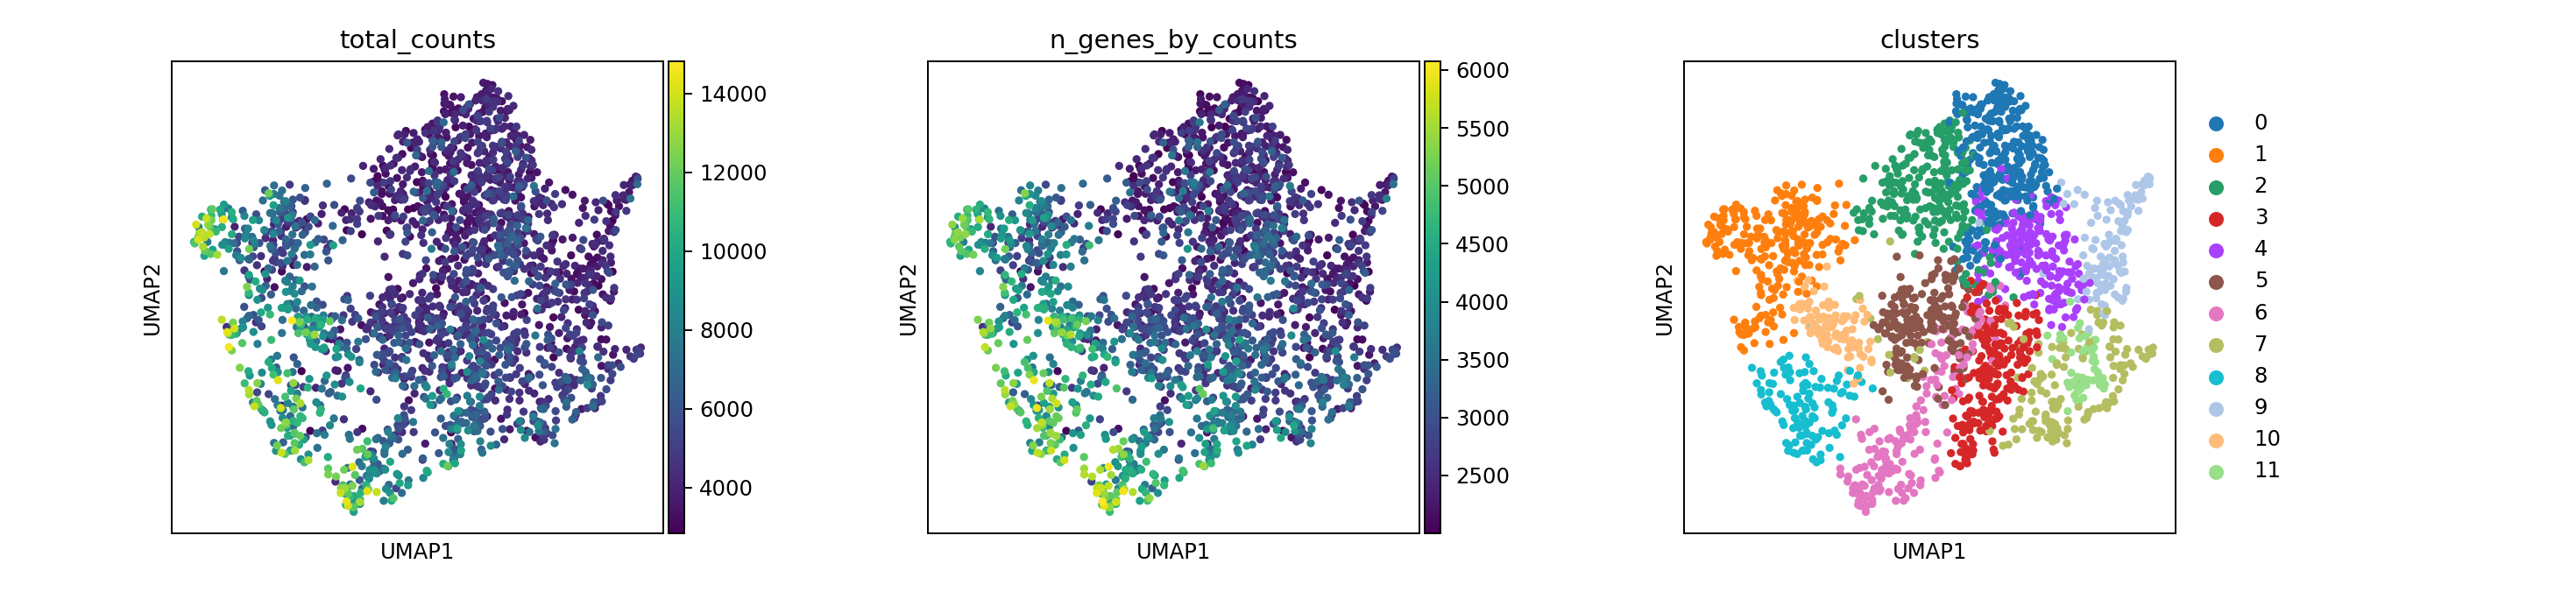

In [27]:
#Do some umap visualisations
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ffpe_human_prostate, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


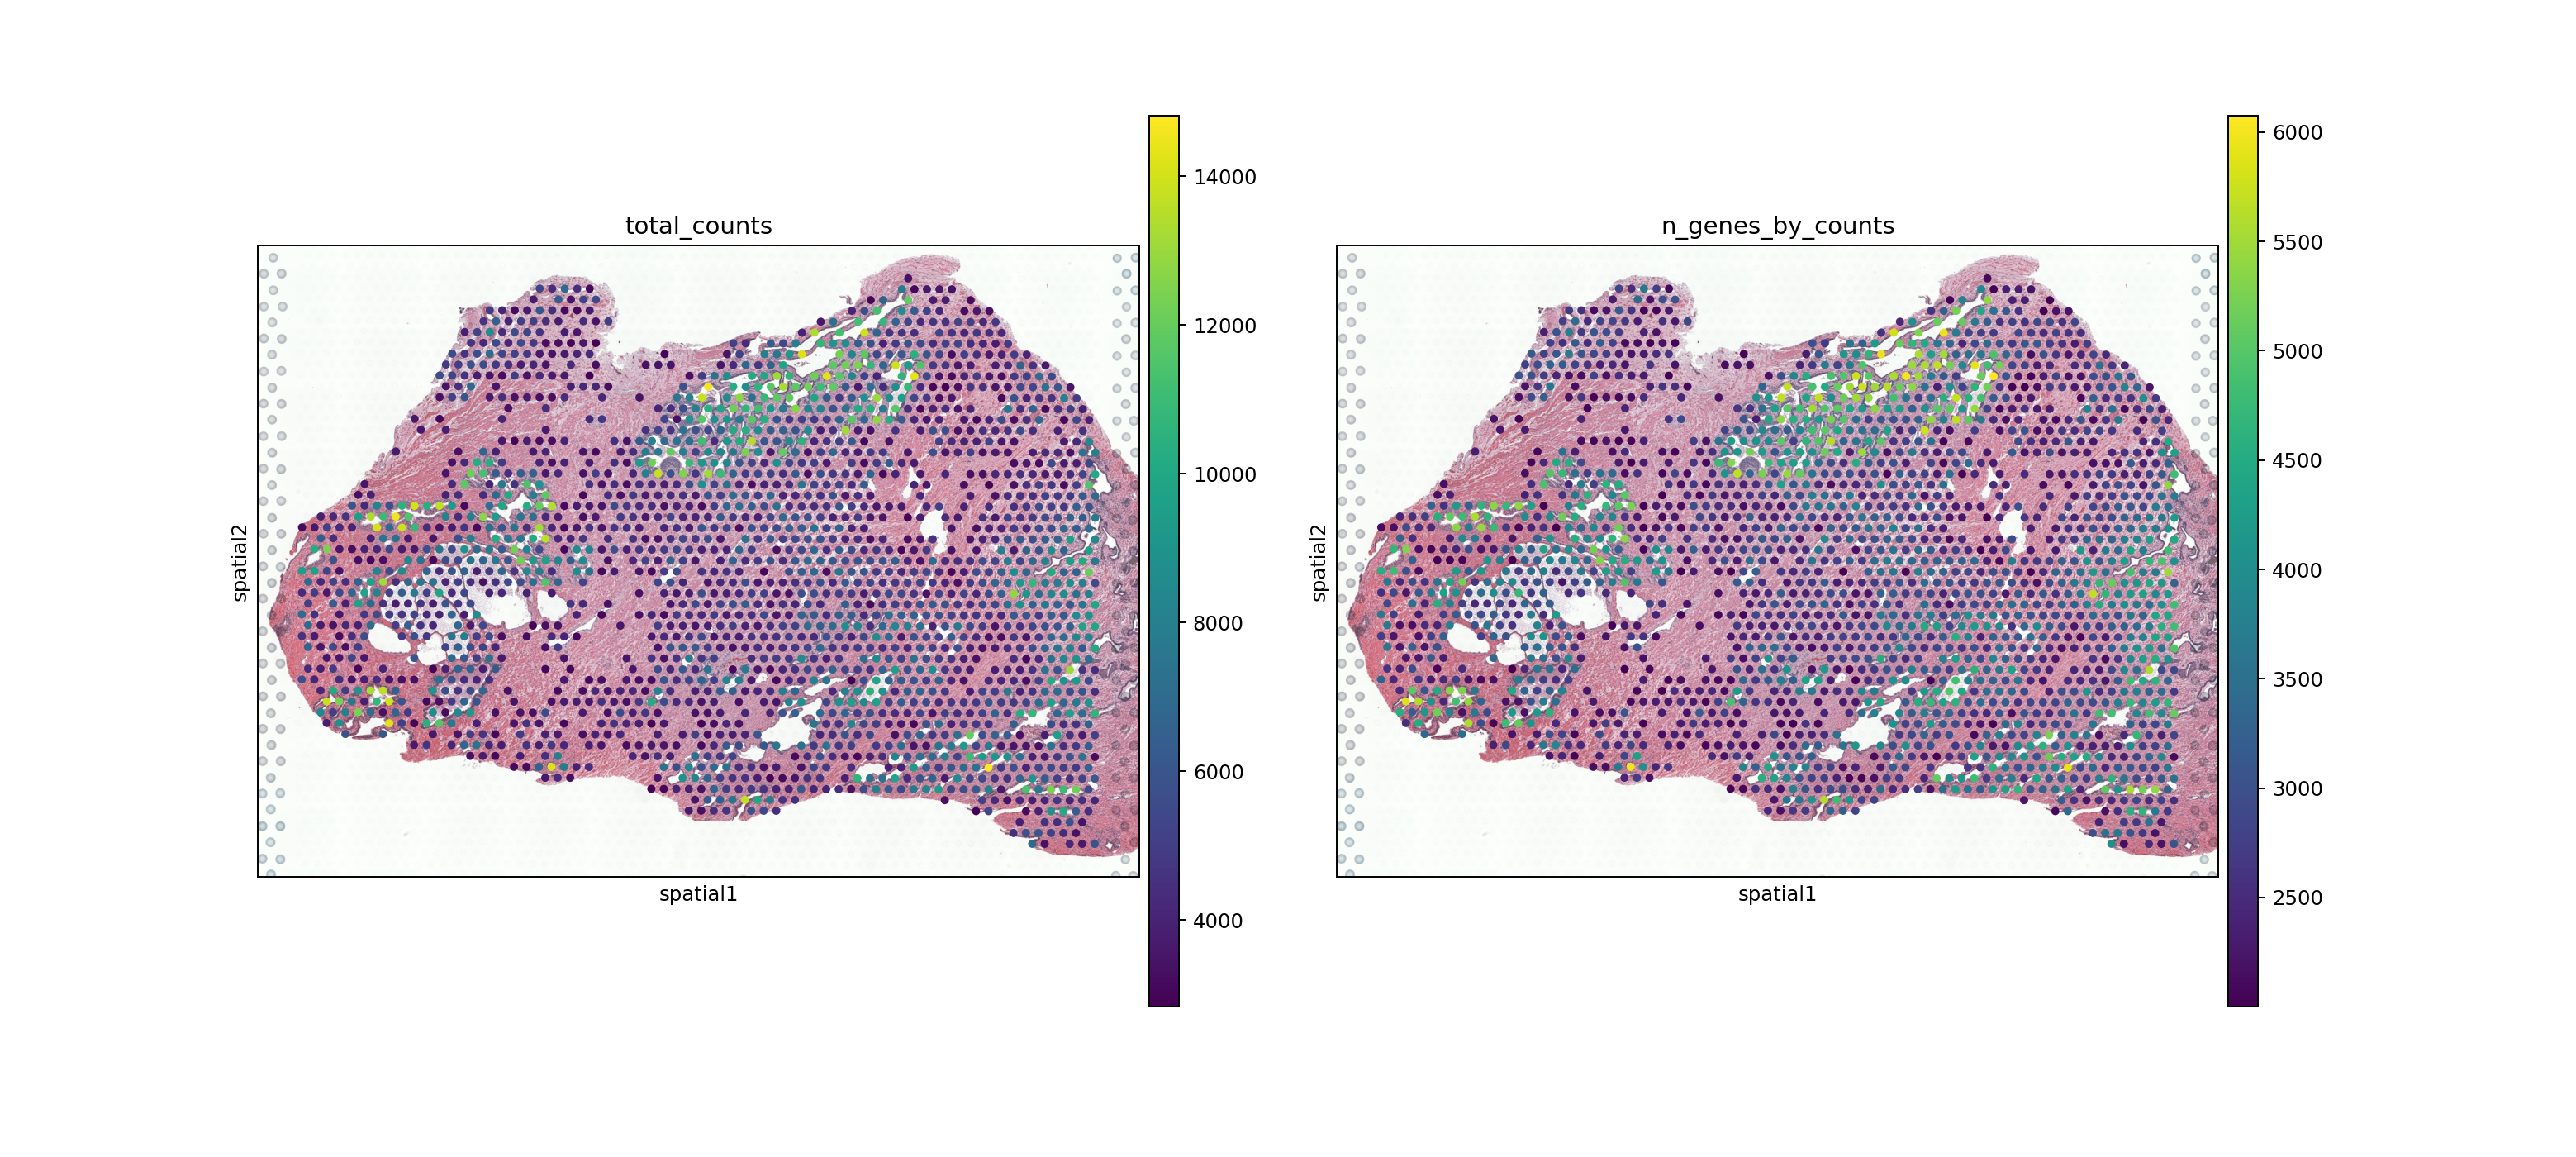

In [28]:
#Visualise in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(ffpe_human_prostate, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<IPython.core.display.Javascript object>


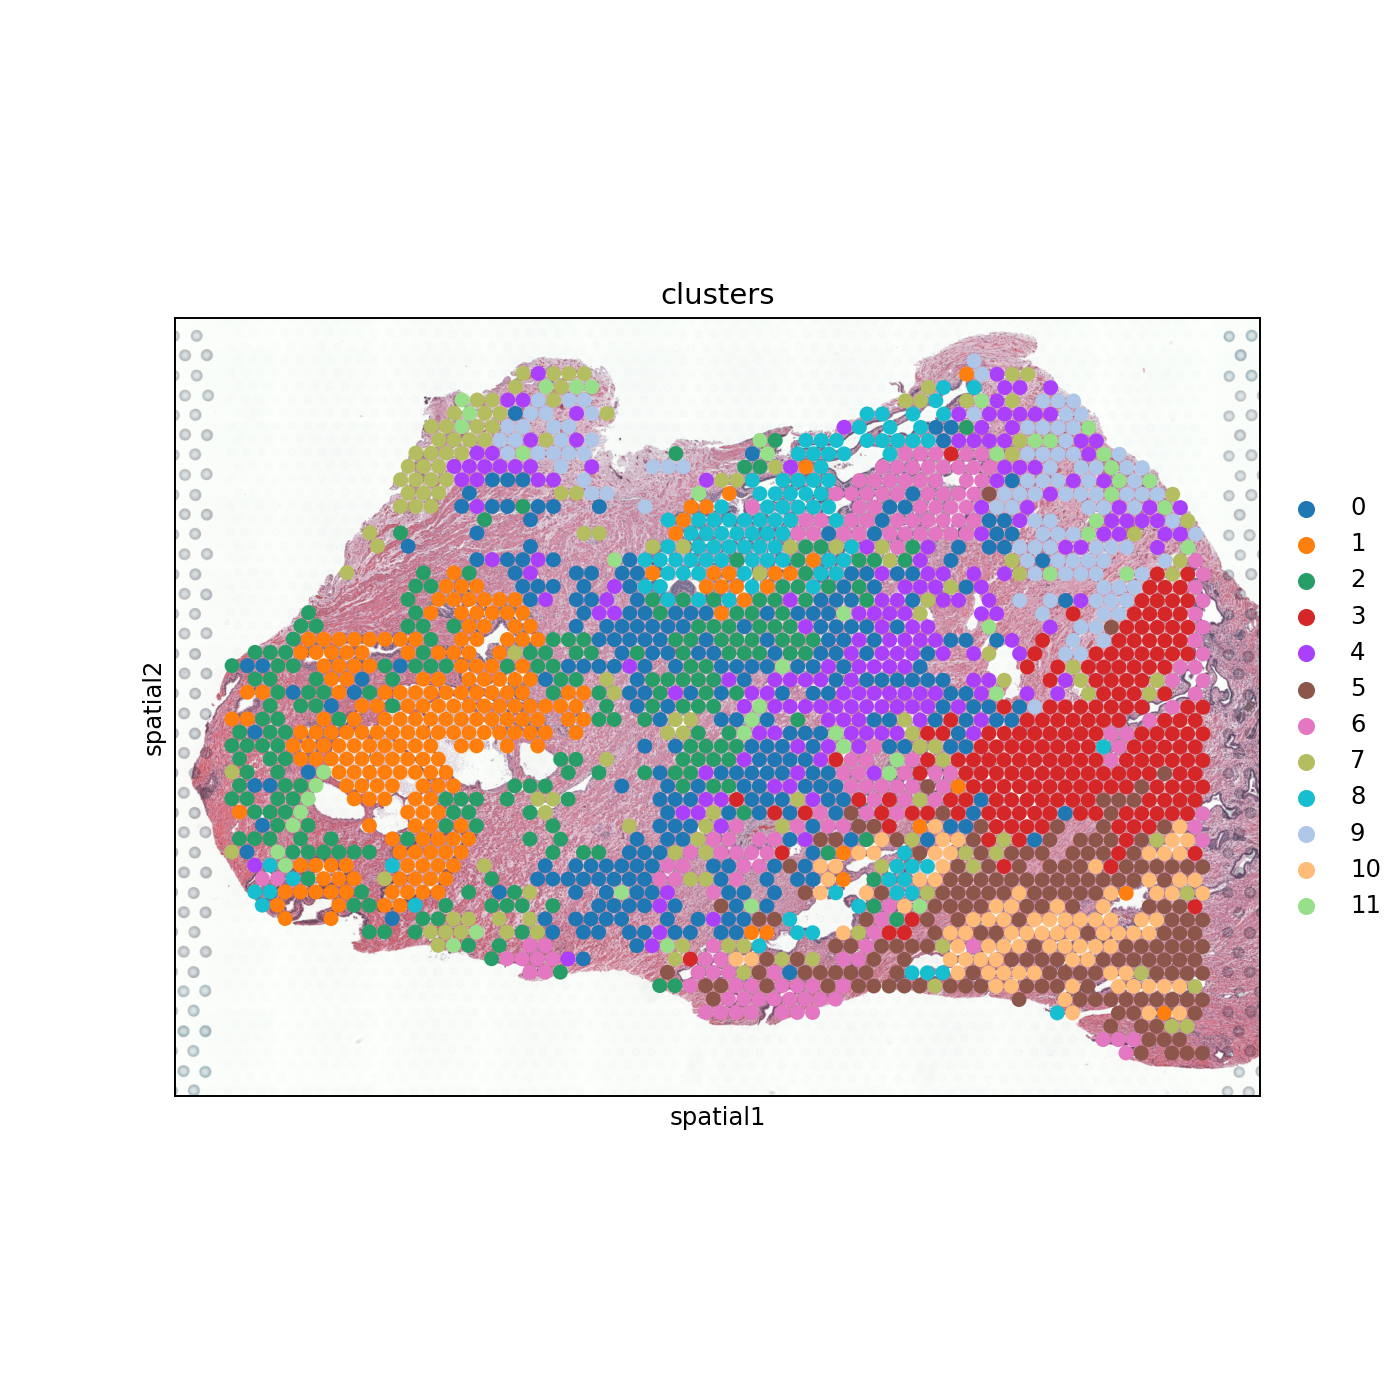

In [29]:
#Visualise cell type clusters by spatial organisation
sc.pl.spatial(ffpe_human_prostate, img_key="hires", color="clusters", size=1.5)

categories: 0, 1, 2, etc.
var_group_labels: 5


<IPython.core.display.Javascript object>


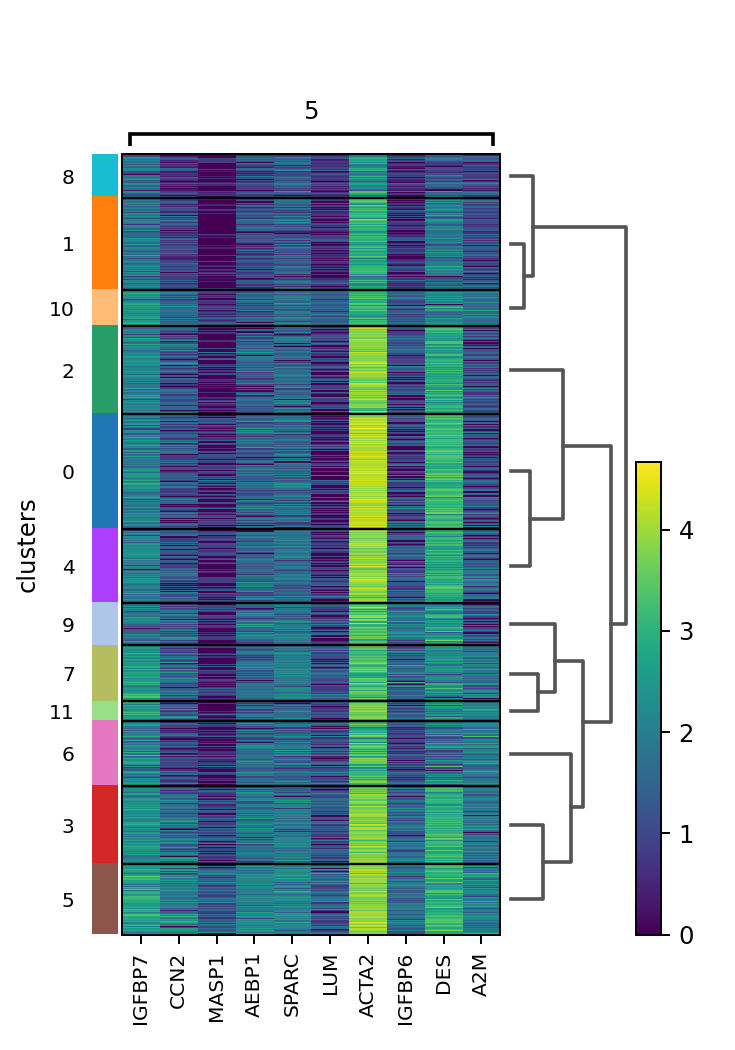

In [30]:
#Compute marker genes across all clusters and plot heatmap of the top 10 markers in each cluster
sc.tl.rank_genes_groups(ffpe_human_prostate, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(ffpe_human_prostate, groups="5", n_genes=10, groupby="clusters")

### Write out necessary files

In [31]:
##write this AnnData object to a didfferent file format
ffpe_human_prostate.write_h5ad(filename='ffpe_human_prostate.h5ad', compression=None, compression_opts=None, force_dense=None, as_dense=())

In [ ]:
#Write out normalised dataframe with expression values to file so it can be read back in for this purpose
ffpe_human_prostate.write_csvs('preprocessed_output/',skip_data=False)

### Perform SVG ansysis with SpatialDE

In [ ]:
%%time
#Now try and find SVGs with SpatialDE
#We need to convert normalised counts into a DF for spatial DE

counts = pd.DataFrame(ffpe_human_prostate.X.todense(), columns=ffpe_human_prostate.var_names, index=ffpe_human_prostate.obs_names)
coord = pd.DataFrame(ffpe_human_prostate.obsm['spatial'], columns=['x_coord', 'y_coord'], index=ffpe_human_prostate.obs_names)
results = SpatialDE.run(coord, counts)
results.to_csv('ffpe_prostate_spatialde_all_svgs.csv')

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/14181 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

  0%|          | 0/14181 [00:00<?, ?it/s]

In [39]:
#Sort results for all qvals >= 0.05 and add them to file
results_filtered = results[results["qval"] <= 0.05]
results_filtered = results_filtered.sort_values(by="qval")
results_filtered.to_csv('ffpe_human_prostate_sigß_svgs_spatialde.csv')
results_filtered

FSV  M        g            l  max_delta       max_ll  max_mu_hat  \
7107   0.142110  4    CLDN7   941.140543   5.874999  -538.112934    0.179323   
6886   0.136232  4      VCL   941.140543   6.170495 -1714.989044    1.027237   
6883   0.234129  4    DDIT4   941.140543   3.183472 -1829.084179    1.034557   
6878   0.683619  4     MSMB   941.140543   0.450398 -2025.261876    2.425995   
6877   0.178360  4     SVIL   941.140543   4.483155 -1684.994935    1.133234   
...         ... ..      ...          ...        ...          ...         ...   
10664  0.008146  4    PHF19  3274.754917  93.491129 -1020.880639    0.275498   
13472  0.006234  4    RSPO1  6108.589804  78.137846    33.327299    0.086344   
12629  0.013268  4    PLIN4  3274.754917  57.104345  -371.853729    0.115673   
12650  0.049296  4   SH2D3A  3274.754917  14.808123    37.011400    0.086866   
11576  0.039050  4  ALOX5AP  3274.754917  18.894857   422.196100    0.077556   

       max_s2_t_hat model     n    s2_FSV  s2_logdelta      time          BIC  \
7107       0.016233    SE  2051  0.000028     0.001745  0.001662  1106.730199   
6886       0.065689    SE  2051  0.000031     0.002051  0.001487  3460.482420   
6883       0.119214    SE  2051  0.000037     0.001188  0.002020  3688.672689   
6878       0.861850    SE  2051  0.000020     0.000476  0.001472  4081.028084   
6877       0.085627    SE  2051  0.000030     0.001372  0.001635  3400.494201   
...             ...   ...   ...       ...          ...       ...          ...   
10664      0.001835    SE  2051  0.000016     0.182403  0.002666  2072.265609   
13472      0.000730    SE  2051  0.000019     0.363577  0.001458   -36.150267   
12629      0.001492    SE  2051  0.000041     0.180340  0.002697   774.211789   
12650      0.003775    SE  2051  0.000246     0.089649  0.002659   -43.518470   
11576      0.002040    SE  2051  0.000210     0.117028  0.003218  -813.887868   

       max_ll_null          LLR      pval      qval  
7107   -635.255571    97.142637  0.000000  0.000000  
6886  -1802.804345    87.815301  0.000000  0.000000  
6883  -2011.922871   182.838692  0.000000  0.000000  
6878  -3109.233226  1083.971349  0.000000  0.000000  
6877  -1816.625736   131.630801  0.000000  0.000000  
...            ...          ...       ...       ...  
10664 -1027.924965     7.044326  0.007952  0.049566  
13472    26.285189     7.042110  0.007962  0.049606  
12629  -378.894956     7.041227  0.007965  0.049608  
12650    29.975969     7.035432  0.007991  0.049747  
11576   415.166263     7.029836  0.008016  0.049881  

[2279 rows x 18 columns]